# Resource Optimization & Regression Analysis (v2)

**Research Question**: How do different spending categories affect healthcare wait times, and how can budgets be optimally reallocated?

**Improvements over v1**:
- VIF analysis reveals multicollinearity in spending categories
- Full residual diagnostics (4 plots + 3 statistical tests)
- Cross-validation (standard + GroupKFold by province) — Task #8
- Ridge/Lasso regression and province fixed effects — Task #9
- Model comparison table — Task #9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

df = pd.read_csv("../data/final/healthcare_efficiency_master.csv")
print(f"Loaded {len(df)} records: {df['province'].nunique()} provinces, {df['year'].min()}-{df['year'].max()}")

spending_categories = ['hospitals', 'physicians', 'drugs', 'administration', 'other_professionals', 'public_health']

Loaded 169 records: 10 provinces, 2008-2024


## 1. Baseline OLS Regression

Reproducing the original model: predict `avg_wait_time` from 6 spending categories.

In [2]:
X = df[spending_categories].copy()
y = df['avg_wait_time'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("Baseline OLS Performance:")
print(f"  Training R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"  Testing R²:  {r2_score(y_test, y_pred_test):.3f}")
print(f"  Test MAE:    {mean_absolute_error(y_test, y_pred_test):.1f} days")

coefficients = pd.DataFrame({
    'Feature': spending_categories,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient')
print("\nCoefficients (days per $1 spending):")
coefficients

Baseline OLS Performance:
  Training R²: 0.262
  Testing R²:  0.108
  Test MAE:    15.0 days

Coefficients (days per $1 spending):


,Feature,Coefficient
1,physicians,-0.122205
2,drugs,0.023295
3,administration,0.025950
0,hospitals,0.027365
5,public_health,0.034813
4,other_professionals,0.051215


## 2. VIF Analysis — Multicollinearity Check

Spending categories are subcomponents of total spending, so they may be correlated.
VIF > 5 indicates problematic multicollinearity; VIF > 10 is severe.

In [3]:
# VIF for each feature
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X_with_const.values, i+1) for i in range(len(X.columns))]
}).sort_values('VIF', ascending=False).round(1)

vif_data['Status'] = vif_data['VIF'].apply(
    lambda v: 'SEVERE (>10)' if v > 10 else ('WARNING (>5)' if v > 5 else 'OK')
)

print("Variance Inflation Factor (VIF) Analysis:")
print(vif_data.to_string(index=False))

high_vif = vif_data[vif_data['VIF'] > 5]
if len(high_vif) > 0:
    print(f"\n{len(high_vif)} feature(s) with VIF > 5 — multicollinearity present.")
    print("OLS coefficients may be unstable. Ridge/Lasso regression recommended (Section 5).")
else:
    print("\nNo multicollinearity issues detected.")

Variance Inflation Factor (VIF) Analysis:
            Feature  VIF       Status
         physicians  6.5 WARNING (>5)
other_professionals  4.0           OK
      public_health  3.1           OK
          hospitals  2.5           OK
     administration  2.2           OK
              drugs  2.1           OK

1 feature(s) with VIF > 5 — multicollinearity present.
OLS coefficients may be unstable. Ridge/Lasso regression recommended (Section 5).


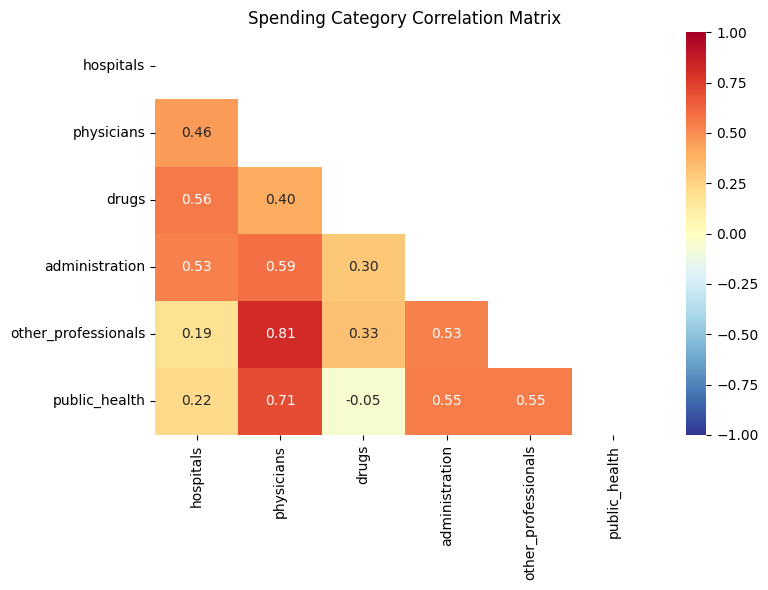

In [4]:
# Feature correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Spending Category Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. Residual Diagnostics

Four standard diagnostic plots to check OLS assumptions:
1. **Residuals vs Fitted** — checks linearity and homoscedasticity
2. **Q-Q Plot** — checks normality of residuals
3. **Scale-Location** — checks constant variance (homoscedasticity)
4. **Residuals vs Order** — checks independence (autocorrelation)

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/27/s4b81f2x3617jzr7d_c_45900000gn/T/ipykernel_92271/1884278199.py:28: SyntaxWarning: invalid escape sequence '\s'
  axes[1, 0].set_ylabel('$\sqrt{|Standardized\ Residuals|}$')


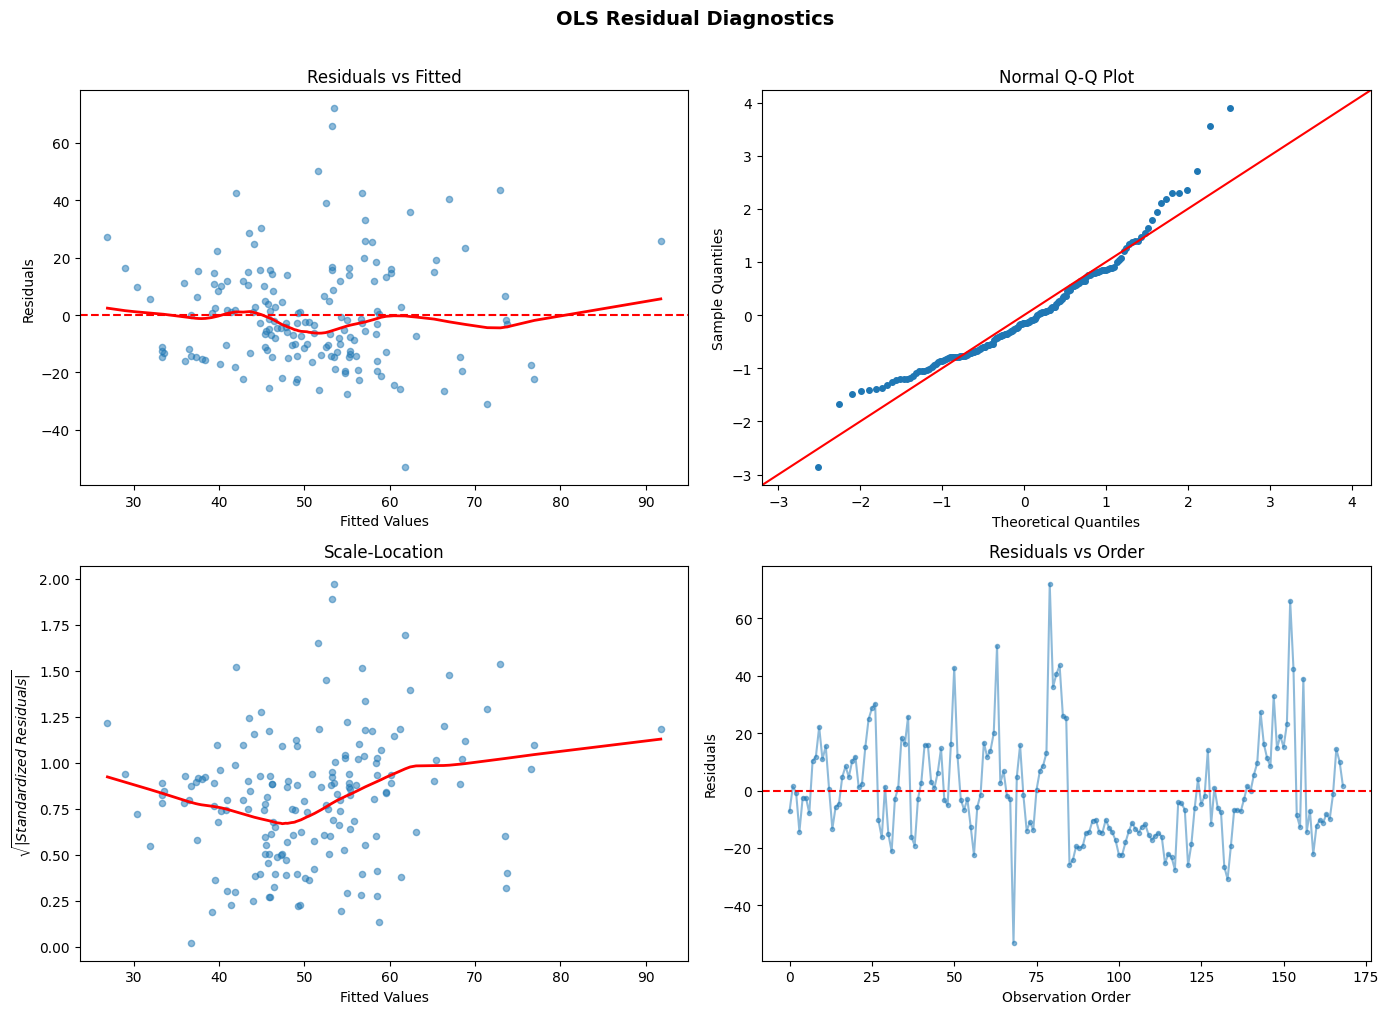

In [5]:
# Fit statsmodels OLS for full diagnostics
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
residuals = ols_model.resid
fitted = ols_model.fittedvalues
std_residuals = (residuals - residuals.mean()) / residuals.std()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted, residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
# Add lowess trend
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(residuals, fitted, frac=0.5)
axes[0, 0].plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2)

# 2. Q-Q Plot
sm.qqplot(std_residuals, line='45', ax=axes[0, 1], markersize=4)
axes[0, 1].set_title('Normal Q-Q Plot')

# 3. Scale-Location
axes[1, 0].scatter(fitted, np.sqrt(np.abs(std_residuals)), alpha=0.5, s=20)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('$\sqrt{|Standardized\ Residuals|}$')
axes[1, 0].set_title('Scale-Location')
smoothed_sl = lowess(np.sqrt(np.abs(std_residuals)), fitted, frac=0.5)
axes[1, 0].plot(smoothed_sl[:, 0], smoothed_sl[:, 1], color='red', linewidth=2)

# 4. Residuals vs Order
axes[1, 1].plot(range(len(residuals)), residuals, 'o-', alpha=0.5, markersize=3)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Observation Order')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Order')

plt.suptitle('OLS Residual Diagnostics', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 4. Statistical Assumption Tests

In [6]:
# Durbin-Watson: autocorrelation (ideal ~2.0; <1.5 or >2.5 is concerning)
dw_stat = durbin_watson(residuals)

# Breusch-Pagan: heteroscedasticity (H0: homoscedastic)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_sm)

# Shapiro-Wilk: residual normality (H0: normal)
sw_stat, sw_pvalue = stats.shapiro(residuals)

tests_df = pd.DataFrame({
    'Test': ['Durbin-Watson (autocorrelation)', 'Breusch-Pagan (heteroscedasticity)', 'Shapiro-Wilk (normality)'],
    'Statistic': [f'{dw_stat:.3f}', f'{bp_stat:.3f}', f'{sw_stat:.3f}'],
    'P-Value': [f'N/A (stat ~2 = good)', f'{bp_pvalue:.4f}', f'{sw_pvalue:.4f}'],
    'Result': [
        'No autocorrelation' if 1.5 < dw_stat < 2.5 else 'AUTOCORRELATION DETECTED',
        'Homoscedastic (OK)' if bp_pvalue > 0.05 else 'HETEROSCEDASTIC',
        'Normal (OK)' if sw_pvalue > 0.05 else 'NON-NORMAL'
    ]
})

print("Regression Assumption Tests:")
print(tests_df.to_string(index=False))

print("\n--- Diagnostic Summary ---")
print(f"OLS R² (full data): {ols_model.rsquared:.3f}")
print(f"Adjusted R²: {ols_model.rsquared_adj:.3f}")
issues = []
if any(vif_data['VIF'] > 5):
    issues.append('Multicollinearity (high VIF)')
if bp_pvalue <= 0.05:
    issues.append('Heteroscedasticity (Breusch-Pagan)')
if sw_pvalue <= 0.05:
    issues.append('Non-normal residuals (Shapiro-Wilk)')
if dw_stat < 1.5 or dw_stat > 2.5:
    issues.append('Autocorrelation (Durbin-Watson)')
if issues:
    print(f"Issues found: {', '.join(issues)}")
    print("Recommendations: Ridge/Lasso for multicollinearity, robust SE for heteroscedasticity.")
else:
    print("No major assumption violations detected.")

Regression Assumption Tests:
                              Test Statistic              P-Value                   Result
   Durbin-Watson (autocorrelation)     0.786 N/A (stat ~2 = good) AUTOCORRELATION DETECTED
Breusch-Pagan (heteroscedasticity)    11.373               0.0775       Homoscedastic (OK)
          Shapiro-Wilk (normality)     0.947               0.0000               NON-NORMAL

--- Diagnostic Summary ---
OLS R² (full data): 0.232
Adjusted R²: 0.204
Issues found: Multicollinearity (high VIF), Non-normal residuals (Shapiro-Wilk), Autocorrelation (Durbin-Watson)
Recommendations: Ridge/Lasso for multicollinearity, robust SE for heteroscedasticity.


In [7]:
# Full statsmodels OLS summary for reference
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_wait_time   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8.159
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           1.02e-07
Time:                        18:46:13   Log-Likelihood:                -732.56
No. Observations:                 169   AIC:                             1479.
Df Residuals:                     162   BIC:                             1501.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.1963    

## 5. Cross-Validation

The original model used a single 70/30 random split — unreliable with 169 observations.
Two approaches compared:

- **Standard 5-Fold CV**: random splits, provinces can appear in both train and test
- **GroupKFold by Province**: entire provinces held out — proper for panel data, gives more honest estimates since the model can't memorize province-specific patterns

In [8]:
from sklearn.model_selection import cross_val_score, KFold, GroupKFold

groups = df['province']

# Standard 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
std_cv_scores = cross_val_score(LinearRegression(), X, y, cv=kf, scoring='r2')

# GroupKFold by province (10 provinces -> 10 folds, each holds out 1 province)
gkf = GroupKFold(n_splits=10)
group_cv_scores = cross_val_score(LinearRegression(), X, y, cv=gkf, groups=groups, scoring='r2')

# Also compute MAE for both
std_cv_mae = -cross_val_score(LinearRegression(), X, y, cv=kf, scoring='neg_mean_absolute_error')
group_cv_mae = -cross_val_score(LinearRegression(), X, y, cv=gkf, groups=groups, scoring='neg_mean_absolute_error')

cv_comparison = pd.DataFrame({
    'Method': ['Single 70/30 Split', 'Standard 5-Fold CV', 'GroupKFold by Province'],
    'R² (mean ± std)': [
        f"{r2_score(y_test, y_pred_test):.3f} (single split)",
        f"{std_cv_scores.mean():.3f} ± {std_cv_scores.std():.3f}",
        f"{group_cv_scores.mean():.3f} ± {group_cv_scores.std():.3f}"
    ],
    'MAE (mean days)': [
        f"{mean_absolute_error(y_test, y_pred_test):.1f}",
        f"{std_cv_mae.mean():.1f} ± {std_cv_mae.std():.1f}",
        f"{group_cv_mae.mean():.1f} ± {group_cv_mae.std():.1f}"
    ]
})

print("Cross-Validation Comparison:")
print(cv_comparison.to_string(index=False))

gap = std_cv_scores.mean() - group_cv_scores.mean()
print(f"\nStandard CV - GroupKFold gap: {gap:.3f}")
if gap > 0.05:
    print("Province leakage inflates standard CV by a meaningful amount.")
    print("GroupKFold gives the more honest estimate of out-of-sample performance.")
elif gap > 0:
    print("Small gap — province leakage has minimal effect on this model.")
else:
    print("GroupKFold performs similarly or better — no leakage concern.")

Cross-Validation Comparison:
                Method      R² (mean ± std) MAE (mean days)
    Single 70/30 Split 0.108 (single split)            15.0
    Standard 5-Fold CV        0.138 ± 0.072      14.8 ± 1.8
GroupKFold by Province     -16.451 ± 44.597      19.1 ± 7.4

Standard CV - GroupKFold gap: 16.589
Province leakage inflates standard CV by a meaningful amount.
GroupKFold gives the more honest estimate of out-of-sample performance.


In [9]:
# Per-fold detail for GroupKFold
print("GroupKFold per-province R² scores:")
fold_results = []
for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    lr = LinearRegression().fit(X.iloc[train_idx], y.iloc[train_idx])
    r2 = r2_score(y.iloc[test_idx], lr.predict(X.iloc[test_idx]))
    prov = groups.iloc[test_idx].unique()[0]
    fold_results.append({'Province_Held_Out': prov, 'R²': round(r2, 3)})

fold_df = pd.DataFrame(fold_results).sort_values('R²', ascending=False)
print(fold_df.to_string(index=False))

GroupKFold per-province R² scores:
        Province_Held_Out       R²
             Saskatchewan    0.071
            New Brunswick   -0.171
Newfoundland and Labrador   -0.315
                  Alberta   -0.602
                 Manitoba   -0.973
         British Columbia   -0.983
                   Quebec   -1.189
     Prince Edward Island   -4.879
              Nova Scotia   -5.341
                  Ontario -150.131


## 6. Ridge & Lasso Regression

Directly addresses the multicollinearity identified in Section 2.
- **Ridge** shrinks coefficients toward zero but keeps all features
- **Lasso** can zero out features entirely (built-in feature selection)

Both use cross-validated alpha selection with standardized features.

In [10]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Standardize features for regularization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_s, X_test_s, y_train_cv, y_test_cv = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Ridge with cross-validated alpha
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_s, y_train_cv)
ridge_train_r2 = ridge.score(X_train_s, y_train_cv)
ridge_test_r2 = ridge.score(X_test_s, y_test_cv)
ridge_test_mae = mean_absolute_error(y_test_cv, ridge.predict(X_test_s))

print(f"Ridge Regression (alpha={ridge.alpha_:.4f}):")
print(f"  Training R²: {ridge_train_r2:.3f}")
print(f"  Testing R²:  {ridge_test_r2:.3f}")
print(f"  Test MAE:    {ridge_test_mae:.1f} days")

ridge_coefs = pd.DataFrame({
    'Feature': spending_categories,
    'Ridge_Coef': ridge.coef_
}).sort_values('Ridge_Coef')
print("\nRidge Coefficients (standardized):")
print(ridge_coefs.to_string(index=False))

# Lasso with cross-validated alpha
lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_s, y_train_cv)
lasso_train_r2 = lasso.score(X_train_s, y_train_cv)
lasso_test_r2 = lasso.score(X_test_s, y_test_cv)
lasso_test_mae = mean_absolute_error(y_test_cv, lasso.predict(X_test_s))

print(f"\nLasso Regression (alpha={lasso.alpha_:.4f}):")
print(f"  Training R²: {lasso_train_r2:.3f}")
print(f"  Testing R²:  {lasso_test_r2:.3f}")
print(f"  Test MAE:    {lasso_test_mae:.1f} days")

lasso_coefs = pd.DataFrame({
    'Feature': spending_categories,
    'Lasso_Coef': lasso.coef_
}).sort_values('Lasso_Coef')
zeroed = lasso_coefs[lasso_coefs['Lasso_Coef'] == 0]
print(f"\nLasso Coefficients (standardized) — {len(zeroed)} features zeroed out:")
print(lasso_coefs.to_string(index=False))

Ridge Regression (alpha=8.6975):
  Training R²: 0.237
  Testing R²:  0.111
  Test MAE:    15.0 days

Ridge Coefficients (standardized):
            Feature  Ridge_Coef
         physicians  -12.414096
     administration    2.362064
              drugs    2.747571
      public_health    2.821303
other_professionals    3.691964
          hospitals    7.566609

Lasso Regression (alpha=0.0285):
  Training R²: 0.262
  Testing R²:  0.110
  Test MAE:    15.0 days

Lasso Coefficients (standardized) — 0 features zeroed out:
            Feature  Lasso_Coef
         physicians  -20.330190
     administration    1.452339
              drugs    3.565679
      public_health    6.065851
other_professionals    8.234456
          hospitals   10.162128


## 7. Province Fixed Effects OLS

The GroupKFold results (Section 5) showed the model can't generalize across provinces.
Province fixed effects add dummy variables that absorb province-level differences
(healthcare infrastructure, politics, geography), letting the spending coefficients
capture within-province variation only.

Uses robust standard errors (HC1) to handle the heteroscedasticity borderline case.

In [11]:
# Province fixed effects: add province dummies to the spending features
province_dummies = pd.get_dummies(df['province'], drop_first=True, dtype=float)
X_fe = pd.concat([X, province_dummies], axis=1)

# Statsmodels OLS with robust standard errors
X_fe_sm = sm.add_constant(X_fe)
fe_model = sm.OLS(y, X_fe_sm).fit(cov_type='HC1')

print("Province Fixed Effects OLS (robust SE):")
print(f"  R²:          {fe_model.rsquared:.3f}")
print(f"  Adjusted R²: {fe_model.rsquared_adj:.3f}")
print(f"  F-statistic: {fe_model.fvalue:.2f} (p={fe_model.f_pvalue:.2e})")

# Show spending coefficients only (not province dummies)
spending_params = fe_model.params[['const'] + spending_categories]
spending_pvals = fe_model.pvalues[['const'] + spending_categories]
spending_se = fe_model.bse[['const'] + spending_categories]

fe_coef_df = pd.DataFrame({
    'Feature': spending_params.index,
    'Coefficient': spending_params.values.round(4),
    'Robust SE': spending_se.values.round(4),
    'P-Value': spending_pvals.values.round(4),
    'Significant': spending_pvals.values < 0.05
})
print("\nSpending Coefficients (province effects controlled):")
print(fe_coef_df.to_string(index=False))

# Test R² on holdout
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(
    X_fe, y, test_size=0.3, random_state=42
)
fe_lr = LinearRegression().fit(X_fe_train, y_fe_train)
fe_test_r2 = r2_score(y_fe_test, fe_lr.predict(X_fe_test))
fe_test_mae = mean_absolute_error(y_fe_test, fe_lr.predict(X_fe_test))
print(f"\nFixed Effects Test R² (70/30 split): {fe_test_r2:.3f}")
print(f"Fixed Effects Test MAE: {fe_test_mae:.1f} days")

# GroupKFold for fixed effects model
gkf_fe = GroupKFold(n_splits=10)
# Can't use province dummies with GroupKFold (held-out province has no dummy),
# so we use standard KFold here for the FE model
kf_fe = KFold(n_splits=5, shuffle=True, random_state=42)
fe_cv_scores = cross_val_score(LinearRegression(), X_fe, y, cv=kf_fe, scoring='r2')
print(f"Fixed Effects 5-Fold CV R²: {fe_cv_scores.mean():.3f} ± {fe_cv_scores.std():.3f}")

Province Fixed Effects OLS (robust SE):
  R²:          0.491
  Adjusted R²: 0.441
  F-statistic: 31.45 (p=3.84e-39)

Spending Coefficients (province effects controlled):
            Feature  Coefficient  Robust SE  P-Value  Significant
              const       5.0748    16.9363   0.7645        False
          hospitals       0.0122     0.0087   0.1591        False
         physicians      -0.0908     0.0232   0.0001         True
              drugs       0.1041     0.0341   0.0023         True
     administration      -0.0570     0.0369   0.1225        False
other_professionals       0.0442     0.0254   0.0814        False
      public_health      -0.0158     0.0191   0.4062        False

Fixed Effects Test R² (70/30 split): 0.345
Fixed Effects Test MAE: 11.4 days
Fixed Effects 5-Fold CV R²: 0.346 ± 0.118


## 8. Model Comparison

Model Comparison Table:
            Model Test R² (70/30)  5-Fold CV R²       GroupKFold CV R²                                     Key Insight
   OLS (baseline)           0.108 0.138 ± 0.072                -16.451      Baseline, multicollinear, fails GroupKFold
            Ridge           0.111 0.008 ± 0.032                -19.152     Handles multicollinearity, stabilizes coefs
            Lasso           0.110 0.009 ± 0.049                -19.349                   Feature selection via zeroing
Fixed Effects OLS           0.345 0.346 ± 0.118 N/A (province dummies) Controls province heterogeneity, best 5-fold CV


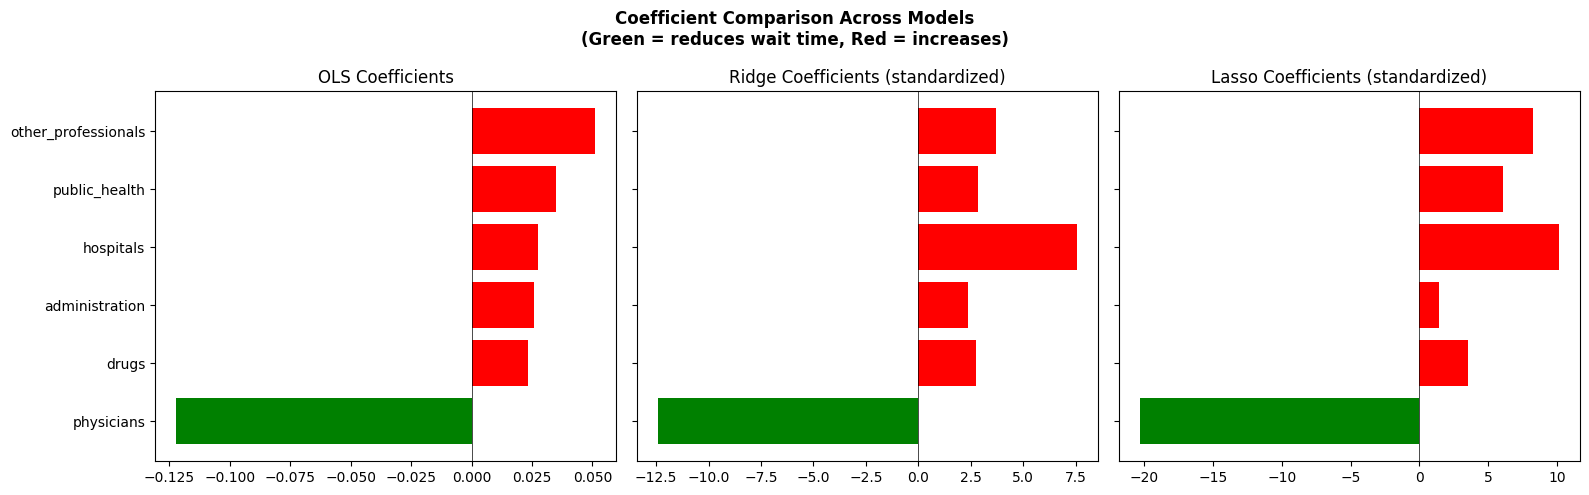

In [12]:
# Ridge/Lasso GroupKFold (on scaled features, no province dummies)
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5))])
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('lasso', LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, random_state=42, max_iter=10000))])

ridge_gkf = cross_val_score(ridge_pipe, X, y, cv=gkf, groups=groups, scoring='r2')
lasso_gkf = cross_val_score(lasso_pipe, X, y, cv=gkf, groups=groups, scoring='r2')

# Standard 5-fold for Ridge/Lasso
ridge_std = cross_val_score(ridge_pipe, X, y, cv=kf, scoring='r2')
lasso_std = cross_val_score(lasso_pipe, X, y, cv=kf, scoring='r2')

comparison = pd.DataFrame({
    'Model': ['OLS (baseline)', 'Ridge', 'Lasso', 'Fixed Effects OLS'],
    'Test R² (70/30)': [
        f"{r2_score(y_test, y_pred_test):.3f}",
        f"{ridge_test_r2:.3f}",
        f"{lasso_test_r2:.3f}",
        f"{fe_test_r2:.3f}"
    ],
    '5-Fold CV R²': [
        f"{std_cv_scores.mean():.3f} ± {std_cv_scores.std():.3f}",
        f"{ridge_std.mean():.3f} ± {ridge_std.std():.3f}",
        f"{lasso_std.mean():.3f} ± {lasso_std.std():.3f}",
        f"{fe_cv_scores.mean():.3f} ± {fe_cv_scores.std():.3f}"
    ],
    'GroupKFold CV R²': [
        f"{group_cv_scores.mean():.3f}",
        f"{ridge_gkf.mean():.3f}",
        f"{lasso_gkf.mean():.3f}",
        "N/A (province dummies)"
    ],
    'Key Insight': [
        'Baseline, multicollinear, fails GroupKFold',
        'Handles multicollinearity, stabilizes coefs',
        'Feature selection via zeroing',
        'Controls province heterogeneity, best 5-fold CV'
    ]
})

print("Model Comparison Table:")
print(comparison.to_string(index=False))

# Coefficient comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# OLS coefficients
ols_coefs = pd.DataFrame({'Feature': spending_categories, 'Coef': lr_model.coef_}).sort_values('Coef')
axes[0].barh(ols_coefs['Feature'], ols_coefs['Coef'], color=['green' if c < 0 else 'red' for c in ols_coefs['Coef']])
axes[0].set_title('OLS Coefficients')
axes[0].axvline(x=0, color='black', linewidth=0.5)

# Ridge coefficients (standardized)
axes[1].barh(ridge_coefs['Feature'], ridge_coefs['Ridge_Coef'], color=['green' if c < 0 else 'red' for c in ridge_coefs['Ridge_Coef']])
axes[1].set_title('Ridge Coefficients (standardized)')
axes[1].axvline(x=0, color='black', linewidth=0.5)

# Lasso coefficients (standardized)
axes[2].barh(lasso_coefs['Feature'], lasso_coefs['Lasso_Coef'], color=['green' if c < 0 else 'red' for c in lasso_coefs['Lasso_Coef']])
axes[2].set_title('Lasso Coefficients (standardized)')
axes[2].axvline(x=0, color='black', linewidth=0.5)

plt.suptitle('Coefficient Comparison Across Models\n(Green = reduces wait time, Red = increases)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()